In [2]:
# encoding=utf8

# Liquor Sales + Linear Regression

+ A liquor store owner in Iowa is looking to expand to new locations and has hired us to investigate the market data for potential new locations. 
+ The business owner is interested in the details of the best model we can fit to the data so that her team can evaluate potential locations for a new storefront. 
+ We built models of total sales using scikit-learn and based on the models we recommend locations to the business owner. 
+ We also perform exploratory analysis with visualizations and statistical analysis. 
Furthermore, we describe the bias-variance tradeoff of the model and evaluate the models fit by using loss functions.

# 1) Problem Statement

The primary goal of this project is to contribute to the expansion plans of a liquor store owner in Iowa, by investigating the market data for potential new locations. 

Furthermore, he is interested in understanding details of the best model that we can fit to the data so that her team can optimally evaluate possible sites for a new storefront.

More concretely, we will predict total sales by county. Note that this is a cross-sectional analysis and no temporal behavior is considered.

# 2) Preamble

Expansion plans traditionally use subsets of the following mix of data:

### 2.1) Demographics

Demographic information can be introduced in a high level of detail (see for example Ref. [1] for an interesting analysis and useful public datasets). Here we will not delve so deeply into that, but some simple demographical data will be used (namely information about income and population). 

We will be interested in several ratios. 

i) The first one is the ratio $r_{{\rm{sv}}}^{(c)}$ between sales and volume for each county i.e. the amount of dollars per liter sold. If $r_{{\rm{sv}}}^{(c)}$ is high in county $(c)$, the stores in that county are, on average, high-end stores. The ratio is given by:

\begin{eqnarray}
r_{{\text{sv}}}^{(c)} = \frac{{{\text{sales in }}c}}{{{\text{volume consumed in }}c}}\,\,\,\,\,\,(1)\nonumber
\end{eqnarray}


(where the upper index $(c)$ is for county). 

ii) Another relevant ratio is the number of stores per area:

\begin{eqnarray}
r_{\text{sa}}^{(c)}=\frac{{\text{number of stores in }}c}{{\text{area of }}c}\,\,\,\,\,(2)\nonumber
\end{eqnarray}
   
The meaning of a high value of $r_{\rm{sa}}^{(c)}$ is not so straightforward since it may indicate either 
   - That the market saturated or 
   - That the county has an extremely strong market which would welcome a new store (an example would be a county close to some major university as discussed in Ref. [3]). 
   
In contrast, a low value of $r_{\rm{sa}}^{(c)}$ may indicate a market with untapped potential or a market with a population not very interested in this type of store (for example, a county with highly religious population).

iii) Another important ratio is consumption/population i.e. the consumption *per capita*:

\begin{eqnarray}
r_{\text{cp}}^{(c)}=\frac{{\text{number of liters consumed in }}c}{{\text{population of }}c}\,\,\,\,\,(3)\nonumber
\end{eqnarray}

The knowledge of the profile of the population in the county (if they are "light" or "heavy" drinkers) would certainly help the owner decide whether to open or not a new storefront there (see Ref. [1,2,3]).

 
### 2.2) Nearby businesses

Competition is a critical component, and can be indirectly measured by the ratio of the number of stores and the population in a given county $c$:
    
\begin{eqnarray}
r_{\text{sp}}^{(c)}=\frac{{\text{number of stores in }}c}{{\text{population of }}c}\,\,\,\,\,(4)\nonumber
\end{eqnarray}

### 2.3) Aggregated human ﬂow/foot traffic

For this information to be useful we would need more granular data (such as apps check-ins as discussed in [7]). Population and population density will be used as proxies.

There is an issue with the meaning of the data that is discussed in the appendix (see the end of the notebook).

# 3) Getting data

Let us take a look at the data. The dataset contains the spirits purchase information of Iowa Class “E” liquor licensees by product and date of purchase.

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)   # Used to display all columns
df_raw = pd.read_csv('../../DataSets/pybk013master/iowa_liquor_sales_proj_2.csv')
df_raw.head()

FileNotFoundError: File b'../../DataSets/pybk013master/iowa_liquor_sales_proj_2.csv' does not exist

In [2]:
from __future__ import division
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
import seaborn as sns
%matplotlib inline
import math
import itertools

## 1) Data Munging and EDA

### a) Checking the time span of the data and dropping 2016 data

It is often convenient to eliminate spaces, commas, etc:

In [3]:
df = df_raw.copy()
df.columns = [c.replace('/','_').replace(' ','_').replace(')','').replace('(','').lower() for c in df.columns.tolist()]

Let us see how many years and months for each year we have. 

- We first convert the data to `datatime`. 
- Using the class attribute `.year` we see that there is data for only two years, namely, 2015 and 2016. 
- Using the class attribute `.month` we see that the data includes 12 months of 2015 but only 3 months of 2016. 

For simplicity we will work only with 2015 data (this restriction can be easily generalized if need be).

In [4]:
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")
print "The years in the data are:", df['date'].dt.year.unique()

The years in the data are: [2015 2016]


In [5]:
for yr in [2015,2016]:
    print "The months in year {}".format(yr),"are", sorted(df[df['date'].dt.year == yr]['date'].dt.month.unique())

The months in year 2015 are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The months in year 2016 are [1, 2, 3]


In [6]:
df = df[(df['date'] < '2016-01-01')]
df.shape

(2184483, 24)

In [7]:
print "The fraction of 2016 data is:", round(df.shape[0]/df_raw.shape[0],2)

The fraction of 2016 data is: 0.81


### b) Selecting rows and columns to keep

This is a rather large dataset and we can eliminate rows and columns that will not be used. 

In [8]:
print "The number of rows and number of columns are:"
print ""
print df.shape[0],"and",df.shape[1]

The number of rows and number of columns are:

2184483 and 24


We will, for now, keep the following columns for the following reasons:

    ['store_number','county','bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',\
                'bottles_sold', 'sale_dollars', 'volume_sold_liters']

The date will be dropped since we will not perform any time series analysis.

In [9]:
cols_to_keep = ['store_number','county','bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',\
                'bottles_sold', 'sale_dollars', 'volume_sold_liters']

df = df[cols_to_keep]

### c) Eliminating symbols in the data, dropping `NaNs` and converting objects to floats

We will:

- Exclude symbols from the DataFrame. Some of the columns include the symbol $\$$ which naturally does not allow for algebraic manipulation. There are several elegant ways to exclude it (see [4]). 
- Convert columns of objects into columns of floats.
- Drop `NaN` values. 

Two ways of excluding dollar signs are:

        1) [x[1:] for x in df['state_bottle_cost']]
    
        2) df['state_bottle_cost'].apply(lambda x: x.strip('$'))
    
We will go with option 2.

In [10]:
cols_with_dollar = ['state_bottle_cost','state_bottle_retail','sale_dollars']
for col in cols_with_dollar:
    df[col] = df[col].apply(lambda x: x.strip('$')).astype('float')

In [11]:
df.dtypes

store_number             int64
county                  object
bottle_volume_ml         int64
state_bottle_cost      float64
state_bottle_retail    float64
bottles_sold             int64
sale_dollars           float64
volume_sold_liters     float64
dtype: object

The commands in the cells below check for:
- The existence of `NaN` values
- How many `NaN` values there are 
- How frequent they are. 

We find that only a tiny fraction of the entries in the `county` column is null, which is not problematic. We will drop them.

In [12]:
null = df.isnull().any() # Column of boolens determining presence of nulls
print "Which colune has null values?",null[null == True].index[0]
print "Number of null values in", null[null == True].index[0], "is:",df.isnull().sum().loc['county']
print "Frequency of null values:", str(100*round(100 * df.isnull().sum().loc['county']/df.shape[0],5)) +'%'

Which colune has null values? county
Number of null values in county is: 1119
Frequency of null values: 5.122%


In [13]:
df.dropna(inplace=True)

### d) Convert store numbers to strings

We convert `store_numbers` to strings:

In [14]:
df[['store_number']] = df[['store_number']].astype(str)

Our `DataFrame` is now:

In [15]:
df.head()

,store_number,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters
0,2191,Lee,750,18.09,27.14,6,162.84,4.50
1,2205,Page,750,18.09,27.14,12,325.68,9.00
2,3549,Lee,150,6.40,9.60,2,19.20,0.30
3,2513,Johnson,1750,35.55,53.34,3,160.02,5.25
4,3942,Tama,150,6.40,9.60,2,19.20,0.30


### e) Look for problematic issues with the data

We use `.describe( )` below to better understand the data. 

In [16]:
# the 'count' row is not very useful and the store_number column is meaningless in this table
df.describe().iloc[1:,1:]   

,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters
mean,9.816396,14.742246,9.877354,130.182613,8.981275
std,14.626429,21.939393,23.699125,405.568937,28.355651
min,0.890000,1.340000,1.000000,1.340000,0.000000
25%,5.540000,8.310000,2.000000,30.720000,1.600000
50%,8.180000,12.300000,6.000000,70.560000,5.250000
75%,11.960000,17.940000,12.000000,135.360000,10.500000
max,6100.000000,9150.000000,3960.000000,106326.000000,3960.000000


Let us look at histograms. We will use the following function (adapted from [1]):

In [17]:
def draw_histograms(df,col,bins):
    df[col].hist(bins=bins);
    plt.title(col);
    plt.xlabel(col);
    plt.xticks(rotation=90);
    plt.show();
    print

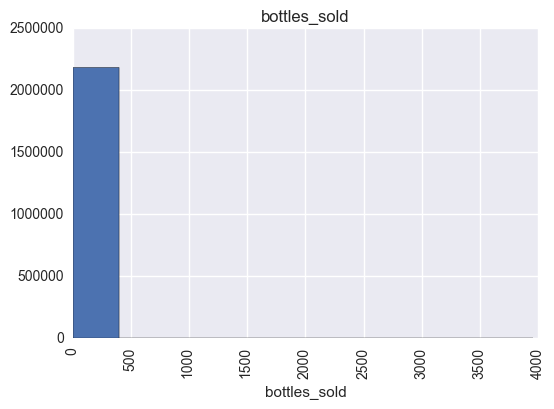

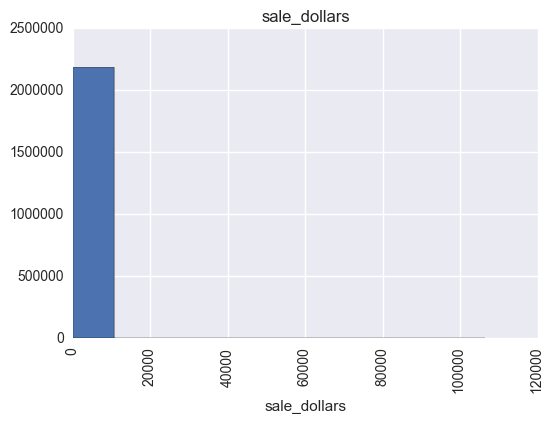

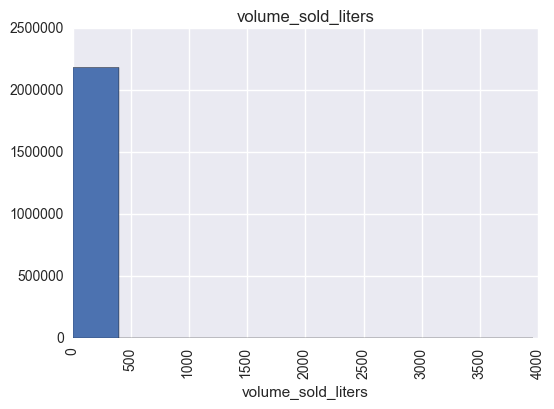

In [18]:
cols = ['bottles_sold', 'sale_dollars', 'volume_sold_liters']
for col in cols:
    draw_histograms(df, col,bins=10)

There are some obvious problems:
- In the columns `bottle_volume_ml` and `volume_sold_liters` there are zero values which can be dropped
- The maximum values are many $\sigma$s larger than the mean for all columns, indicating outliers. Let us drop some outliers. We will choose to restrict some of the columns. We will drop values roughly 2$\sigma$ larger than the means.


### f) Exclude outliers


Keeping outliers in our analysis will inflate the predicted sales. Also, we intend to predict the most likely performance for each store. In other words, we do not want to use exceptionally well-performing stores to make recommendations.  

In [19]:
df1 = df.copy()
print np.mean(df1['bottles_sold'])+ 2*np.std(df1['bottles_sold'])
print np.mean(df1['sale_dollars'])+ 2*np.std(df1['sale_dollars'])
print np.mean(df1['volume_sold_liters'])+ 2*np.std(df1['volume_sold_liters'])

57.2755933042
941.320301085
65.6925625834


Let us correct these:

In [20]:
df1 = df.copy()
cutoffs = (df1['bottle_volume_ml'] > 0) & (df1['bottles_sold'] < 50) & (df1['volume_sold_liters'] < 60) & (df1['sale_dollars'] < 900)
df1 = df1[cutoffs]

In [21]:
df1.describe().iloc[1:,1:]

,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters
mean,9.745472,14.635677,7.968786,99.364086,6.864374
std,6.995164,10.492340,7.830878,100.784662,6.635848
min,0.890000,1.340000,1.000000,1.340000,0.100000
25%,5.510000,8.270000,2.000000,30.000000,1.500000
50%,8.000000,12.000000,6.000000,68.640000,4.800000
75%,11.830000,17.750000,12.000000,132.780000,10.500000
max,498.640000,747.960000,48.000000,899.980000,54.000000


Let us look again at histograms. 

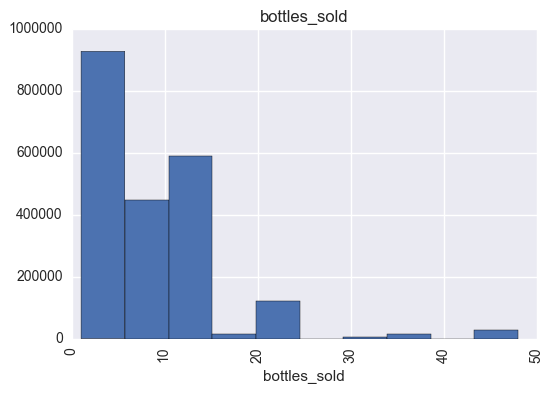

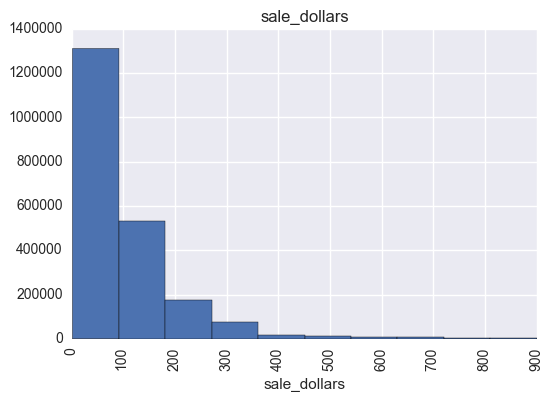

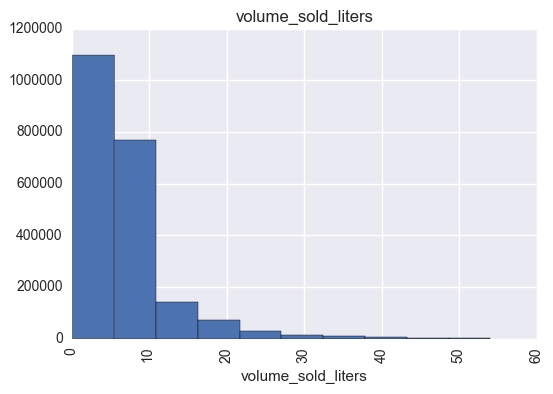

In [22]:
cols = ['bottles_sold', 'sale_dollars', 'volume_sold_liters']
for col in cols:
    draw_histograms(df1, col,bins=10)

# 5) Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.


### a) Aggregating data by county, computing total number of stores and total sales

To obtain the ratios (1)-(4) we need the counties' areas, their populations and the number of stores in them. Let us count the number of stores per county:

In [180]:
df2 = df1.copy()
stores_per_county = df2.groupby(['county'])['store_number'].count()
print stores_per_county.sum()
stores_per_county.head()

2143329


county
Adair        4420
Adams        1797
Allamakee    8595
Appanoose    8582
Audubon      2045
Name: store_number, dtype: int64

In [181]:
df1.columns

Index([u'store_number', u'county', u'bottle_volume_ml', u'state_bottle_cost',
       u'state_bottle_retail', u'bottles_sold', u'sale_dollars',
       u'volume_sold_liters'],
      dtype='object')

Let us computer total sales per county:

### b) Create profit column

Let us first include the profit:

In [182]:
df2['profit'] = (df2['state_bottle_retail'] - df2['state_bottle_cost'])*df2["bottles_sold"]
df2.head()

,store_number,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit
0,2191,Lee,750,18.09,27.14,6,162.84,4.50,54.30
1,2205,Page,750,18.09,27.14,12,325.68,9.00,108.60
2,3549,Lee,150,6.40,9.60,2,19.20,0.30,6.40
3,2513,Johnson,1750,35.55,53.34,3,160.02,5.25,53.37
4,3942,Tama,150,6.40,9.60,2,19.20,0.30,6.40


### c) Count stores per county

In [183]:
cols = ['county', 'bottle_volume_ml', 'state_bottle_cost', \
        'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters', 'profit']

In [184]:
df_county = df2[cols].groupby(['county']).sum()

In [185]:
df_county.head()

,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit
county,,,,,,,
Adair,4455875,40182.62,60373.69,33807,410805.62,32522.35,137466.12
Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,33614.78
Allamakee,9079175,85371.49,128238.38,57833,772843.46,61269.76,258630.44
Appanoose,8360175,82458.44,123839.97,58261,711376.15,53184.66,237792.71
Audubon,2043175,17737.11,26656.07,13978,159547.63,13215.43,53393.70


In [186]:
df_county['num_stores'] = stores_per_county
df_county.reset_index(level=0, inplace=True)
df_county.head()

,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores
0,Adair,4455875,40182.62,60373.69,33807,410805.62,32522.35,137466.12,4420
1,Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,33614.78,1797
2,Allamakee,9079175,85371.49,128238.38,57833,772843.46,61269.76,258630.44,8595
3,Appanoose,8360175,82458.44,123839.97,58261,711376.15,53184.66,237792.71,8582
4,Audubon,2043175,17737.11,26656.07,13978,159547.63,13215.43,53393.70,2045


In [187]:
df_county.isnull().any()

county                 False
bottle_volume_ml       False
state_bottle_cost      False
state_bottle_retail    False
bottles_sold           False
sale_dollars           False
volume_sold_liters     False
profit                 False
num_stores             False
dtype: bool

### d) Calculation of the profit per store

In [189]:
df_county['average_store_profit'] = df_county['profit']/df_county['num_stores']

In [190]:
df_county.head()

,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores,average_store_profit
0,Adair,4455875,40182.62,60373.69,33807,410805.62,32522.35,137466.12,4420,31.100932
1,Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,33614.78,1797,18.706055
2,Allamakee,9079175,85371.49,128238.38,57833,772843.46,61269.76,258630.44,8595,30.090802
3,Appanoose,8360175,82458.44,123839.97,58261,711376.15,53184.66,237792.71,8582,27.708309
4,Audubon,2043175,17737.11,26656.07,13978,159547.63,13215.43,53393.70,2045,26.109389


In [191]:
df_county.isnull().any()

county                  False
bottle_volume_ml        False
state_bottle_cost       False
state_bottle_retail     False
bottles_sold            False
sale_dollars            False
volume_sold_liters      False
profit                  False
num_stores              False
average_store_profit    False
dtype: bool

### e) Calculation sales per volume $r_{{\rm{sv}}}^{(c)}$

In [192]:
df_county['sales_per_litters'] = df_county['sale_dollars']/df_county['volume_sold_liters']

### f) Cut-offs in the aggregate DataFrame

In [193]:
df_county.describe().loc[['mean','std','max']]

,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores,average_store_profit,sales_per_litters
mean,1.994879e+07,2.109874e+05,3.168593e+05,1.725225e+05,2.151211e+06,1.486122e+05,7.188647e+05,21649.787879,30.170016,13.382942
std,4.068975e+07,4.620609e+05,6.938726e+05,4.054011e+05,4.974648e+06,3.237530e+05,1.662030e+06,46543.944487,6.068482,0.999601
max,3.376040e+08,3.868235e+06,5.808917e+06,3.319741e+06,4.132447e+07,2.673001e+06,1.380706e+07,383547.000000,44.859888,15.770199


Consider histograms again:

In [194]:
print df_county.columns.tolist()

['county', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters', 'profit', 'num_stores', 'average_store_profit', 'sales_per_litters']


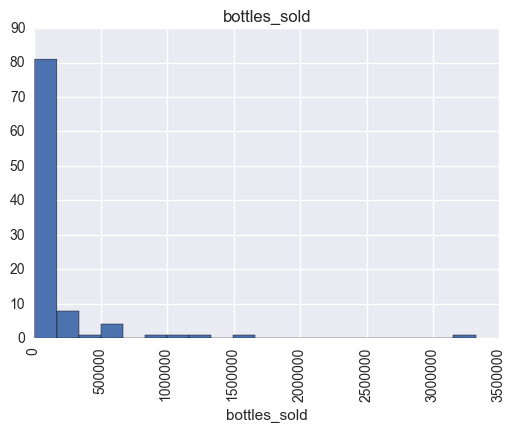

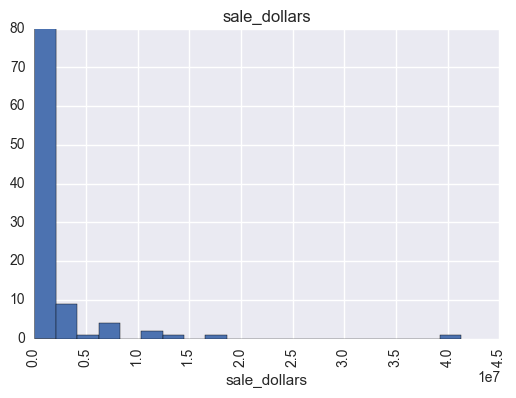

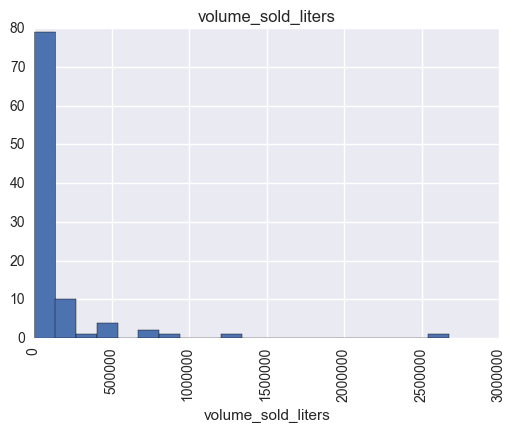

In [195]:
cols = ['bottles_sold', 'sale_dollars', 'volume_sold_liters']
for col in cols:
    draw_histograms(df_county, col,bins=20)

There are two clear outliers which we can remove:

In [196]:
print df_county['bottles_sold'].sort_values(ascending=False).head()
print ""
print df_county.iloc[76].loc['county']

76    3319741
56    1500058
81    1237025
6     1093412
51     927749
Name: bottles_sold, dtype: int64

Polk


In [197]:
print df_county['bottles_sold'].sort_values(ascending=True).head()
print ""
print df_county.iloc[35].loc['county']

35    2512
25    7746
92    8283
1     8446
86    9360
Name: bottles_sold, dtype: int64

Fremont


In [198]:
conditions = (df_county['county'] != 'Polk') & (df_county['county'] != 'Fremont')
df_county = df_county[conditions]

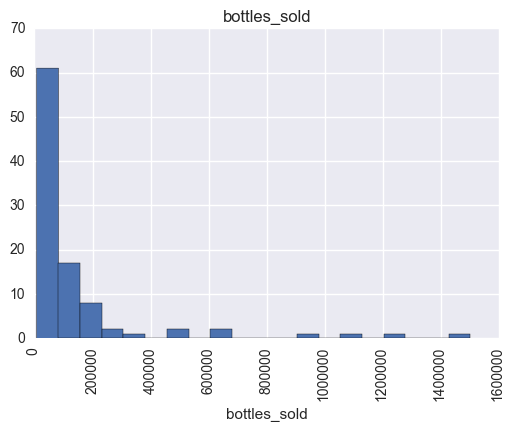

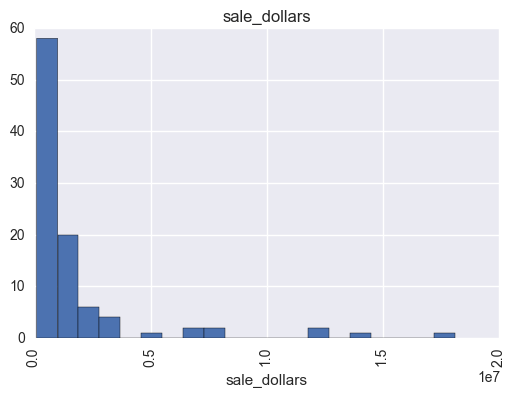

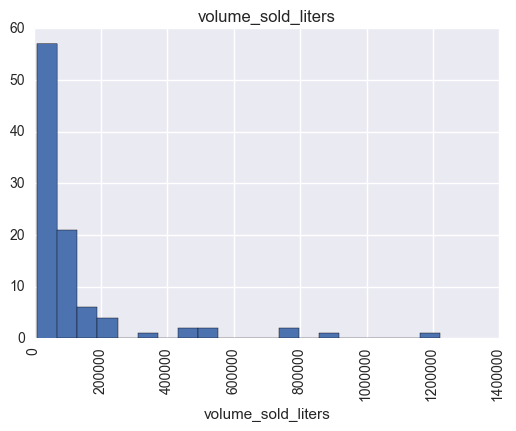

In [200]:
cols = ['bottles_sold', 'sale_dollars', 'volume_sold_liters']
for col in cols:
    draw_histograms(df_county, col,bins=20)

In [201]:
df_county.head()

,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores,average_store_profit,sales_per_litters
0,Adair,4455875,40182.62,60373.69,33807,410805.62,32522.35,137466.12,4420,31.100932,12.631486
1,Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,33614.78,1797,18.706055,13.328281
2,Allamakee,9079175,85371.49,128238.38,57833,772843.46,61269.76,258630.44,8595,30.090802,12.613783
3,Appanoose,8360175,82458.44,123839.97,58261,711376.15,53184.66,237792.71,8582,27.708309,13.375589
4,Audubon,2043175,17737.11,26656.07,13978,159547.63,13215.43,53393.70,2045,26.109389,12.072829


### g) Including population data 

To obtain both $r_{\rm{sp}}^{(c)}$ (stores per person) and $r_{\rm{cp}}^{(c)}$ (alcohol consumption per person) we need data about the population of each county. This dataset is taken from [5]. These are 2016 population estimates (which will be discussed later).

In [230]:
pop = pd.read_csv('pop_iowa_per_county.csv')
del pop['Unnamed: 0']
pop = pop[pop['county'] != 'Polk']
pop = pop[pop['county'] != 'Fremont']
pop.head()

,county,population
0,Adair,7092
1,Adams,3693
2,Allamakee,13884
3,Appanoose,12462
4,Audubon,5678


In [231]:
pop.isnull().any()

county        False
population    False
dtype: bool

We now append to our dataset columns of population, population per store and consumption per store:

In [263]:
df_new = df_county.copy()
df_new = pd.merge(df_new, pop, on= 'county', how='outer')

In [264]:
df_new.isnull().any()

county                  False
bottle_volume_ml        False
state_bottle_cost       False
state_bottle_retail     False
bottles_sold            False
sale_dollars            False
volume_sold_liters      False
profit                  False
num_stores              False
average_store_profit    False
sales_per_litters       False
population              False
dtype: bool

### h) Calculation of ratios $r_{\rm{cp}}^{(c)}$ and $r_{\rm{sp}}^{(c)}$

In [265]:
df_new['store_population_ratio'] = df_new['num_stores']/df_new['population']
df_new['consumption_per_capita'] = df_new['volume_sold_liters']/df_new['population']

In [266]:
df_new.isnull().any()

county                    False
bottle_volume_ml          False
state_bottle_cost         False
state_bottle_retail       False
bottles_sold              False
sale_dollars              False
volume_sold_liters        False
profit                    False
num_stores                False
average_store_profit      False
sales_per_litters         False
population                False
store_population_ratio    False
consumption_per_capita    False
dtype: bool

It is a good idea to export this DataFrame to keep after so many changes: 

In [267]:
df_new.to_csv('df_new.csv')

### i) Including area data

We not import a table containing among other things, areas per county (source [1]):

In [268]:
pd.set_option('display.max_rows', None)

areas = pd.read_csv('ia_zip_city_county_sqkm.csv')
del areas['Unnamed: 0']
areas.columns = ['zip_code', 'city', 'county', 'state', 'county_number', 'area']
areas = areas[['county','area']].groupby(['county'])[['area']].sum()
areas.reset_index(level=0, inplace=True)
areas = areas[(areas['county'] != 'Polk') & (areas['county'] != 'Fremont')]
areas

,county,area
0,Adair,1146.149874
1,Adams,950.420482
2,Allamakee,1640.663925
3,Appanoose,1439.625361
4,Audubon,1011.305224
5,Benton,1589.039934
6,Black Hawk,1658.463133
7,Boone,1172.618576
8,Bremer,1254.612988
9,Buchanan,1437.306002


In [269]:
df_new = pd.merge(df_new, areas, on= 'county', how='outer')

In [270]:
df_new

,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores,average_store_profit,sales_per_litters,population,store_population_ratio,consumption_per_capita,area
0,Adair,4455875,40182.62,6.037369e+04,33807,4.108056e+05,32522.35,1.374661e+05,4420,31.100932,12.631486,7092,0.623237,4.585780,1146.149874
1,Adams,1757403,18103.82,2.717139e+04,8446,1.005968e+05,7547.62,3.361478e+04,1797,18.706055,13.328281,3693,0.486596,2.043764,950.420482
2,Allamakee,9079175,85371.49,1.282384e+05,57833,7.728435e+05,61269.76,2.586304e+05,8595,30.090802,12.613783,13884,0.619058,4.412976,1640.663925
3,Appanoose,8360175,82458.44,1.238400e+05,58261,7.113762e+05,53184.66,2.377927e+05,8582,27.708309,13.375589,12462,0.688654,4.267747,1439.625361
4,Audubon,2043175,17737.11,2.665607e+04,13978,1.595476e+05,13215.43,5.339370e+04,2045,26.109389,12.072829,5678,0.360162,2.327480,1011.305224
5,Benton,7790725,71349.04,1.071595e+05,47699,5.803559e+05,47612.84,1.940870e+05,7731,25.105032,12.189062,25699,0.300829,1.852712,1589.039934
6,Black Hawk,100801227,1107541.37,1.663275e+06,1093412,1.192076e+07,793399.13,3.982880e+06,118229,33.687840,15.024919,132904,0.889582,5.969716,1658.463133
7,Boone,16005831,154407.11,2.319393e+05,120271,1.534234e+06,115554.84,5.129844e+05,16515,31.061724,13.277107,26532,0.622456,4.355301,1172.618576
8,Bremer,17767453,173326.87,2.603925e+05,113551,1.487074e+06,114021.43,4.976283e+05,17746,28.041717,13.042060,24798,0.715622,4.598009,1254.612988
9,Buchanan,12168450,121504.75,1.824907e+05,89429,1.140914e+06,84484.18,3.814875e+05,12653,30.149961,13.504469,20992,0.602753,4.024589,1437.306002


In [271]:
df_new.isnull().any()

county                    False
bottle_volume_ml          False
state_bottle_cost         False
state_bottle_retail       False
bottles_sold              False
sale_dollars              False
volume_sold_liters        False
profit                    False
num_stores                False
average_store_profit      False
sales_per_litters         False
population                False
store_population_ratio    False
consumption_per_capita    False
area                      False
dtype: bool

### j) Calculate stores per area $r_{\rm{sa}}^{(c)}$

In [272]:
df_new['stores_per_area'] = df_new['num_stores']/df_new['area']

In [273]:
df_new.head()

,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores,average_store_profit,sales_per_litters,population,store_population_ratio,consumption_per_capita,area,stores_per_area
0,Adair,4455875,40182.62,60373.69,33807,410805.62,32522.35,137466.12,4420,31.100932,12.631486,7092,0.623237,4.585780,1146.149874,3.856389
1,Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,33614.78,1797,18.706055,13.328281,3693,0.486596,2.043764,950.420482,1.890742
2,Allamakee,9079175,85371.49,128238.38,57833,772843.46,61269.76,258630.44,8595,30.090802,12.613783,13884,0.619058,4.412976,1640.663925,5.238733
3,Appanoose,8360175,82458.44,123839.97,58261,711376.15,53184.66,237792.71,8582,27.708309,13.375589,12462,0.688654,4.267747,1439.625361,5.961273
4,Audubon,2043175,17737.11,26656.07,13978,159547.63,13215.43,53393.70,2045,26.109389,12.072829,5678,0.360162,2.327480,1011.305224,2.022139


In [274]:
# Taking care of outliers:
#df4 = df4[df4['County'] != 'Fremont']
#df4 = df2[df4['County'] != 'Davis']

### l) Download a database about incomes:

In [275]:
income = pd.read_excel('iowa_incomes.xls')
col_names = [c.replace('/','_').replace(' ','_').replace(')','').replace('(','').lower() for c in income.columns.tolist()]
income.columns = col_names
income.head(5)

,county,per_capita_income,median_household_income,median_family_income,number_of_households
0,Adair,23497,45202,57287,3292
1,Adams,23549,40368,52782,1715
2,Allamakee,21349,46623,55926,5845
3,Appanoose,20084,34689,41250,5627
4,Audubon,24207,42717,58641,2617


In [276]:
df_new = df_new.merge(income, how='left', on='county')
df_new.head()

,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores,average_store_profit,sales_per_litters,population,store_population_ratio,consumption_per_capita,area,stores_per_area,per_capita_income,median_household_income,median_family_income,number_of_households
0,Adair,4455875,40182.62,60373.69,33807,410805.62,32522.35,137466.12,4420,31.100932,12.631486,7092,0.623237,4.585780,1146.149874,3.856389,23497,45202,57287,3292
1,Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,33614.78,1797,18.706055,13.328281,3693,0.486596,2.043764,950.420482,1.890742,23549,40368,52782,1715
2,Allamakee,9079175,85371.49,128238.38,57833,772843.46,61269.76,258630.44,8595,30.090802,12.613783,13884,0.619058,4.412976,1640.663925,5.238733,21349,46623,55926,5845
3,Appanoose,8360175,82458.44,123839.97,58261,711376.15,53184.66,237792.71,8582,27.708309,13.375589,12462,0.688654,4.267747,1439.625361,5.961273,20084,34689,41250,5627
4,Audubon,2043175,17737.11,26656.07,13978,159547.63,13215.43,53393.70,2045,26.109389,12.072829,5678,0.360162,2.327480,1011.305224,2.022139,24207,42717,58641,2617


In [277]:
df_new.isnull().any()[df_new.isnull().any() == True]

Series([], dtype: bool)

# 6) Refine the data

Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [278]:
df_final = df_new.copy()

In [279]:
df_final.head()

,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores,average_store_profit,sales_per_litters,population,store_population_ratio,consumption_per_capita,area,stores_per_area,per_capita_income,median_household_income,median_family_income,number_of_households
0,Adair,4455875,40182.62,60373.69,33807,410805.62,32522.35,137466.12,4420,31.100932,12.631486,7092,0.623237,4.585780,1146.149874,3.856389,23497,45202,57287,3292
1,Adams,1757403,18103.82,27171.39,8446,100596.80,7547.62,33614.78,1797,18.706055,13.328281,3693,0.486596,2.043764,950.420482,1.890742,23549,40368,52782,1715
2,Allamakee,9079175,85371.49,128238.38,57833,772843.46,61269.76,258630.44,8595,30.090802,12.613783,13884,0.619058,4.412976,1640.663925,5.238733,21349,46623,55926,5845
3,Appanoose,8360175,82458.44,123839.97,58261,711376.15,53184.66,237792.71,8582,27.708309,13.375589,12462,0.688654,4.267747,1439.625361,5.961273,20084,34689,41250,5627
4,Audubon,2043175,17737.11,26656.07,13978,159547.63,13215.43,53393.70,2045,26.109389,12.072829,5678,0.360162,2.327480,1011.305224,2.022139,24207,42717,58641,2617


### a) Choosing predictors

- We must look for strong correlations between predictors to avoid problems with multicollinearity. 
- Predictors that change very little may have little impact.


### a) Correlations between sales and predictors

In [280]:
cols_to_keep = ['sale_dollars', 'num_stores', 'population', 'store_population_ratio',  'area', u'per_capita_income', u'median_household_income', u'median_family_income']

In [281]:
df_final[cols_to_keep].corr().loc['sale_dollars'].sort_values(ascending=False).iloc[1:]

num_stores                 0.995047
population                 0.974590
per_capita_income          0.348343
store_population_ratio     0.344187
median_family_income       0.340245
area                       0.281804
median_household_income    0.190911
Name: sale_dollars, dtype: float64

### d) Correlations between predictors

Observations:

- We see from the correlation matrices below that `num_stores` and `stores_per_area` are highly correlated. Furthermore, both are highly correlated to the target variable `sale_dollars`.
- Both things also happen with `store_population_ratio` and `consumption_per_capita`.

In [282]:
cols_to_keep = ['num_stores', 'store_population_ratio', 'consumption_per_capita', 'stores_per_area', u'per_capita_income']
df_final[cols_to_keep].corr()

,num_stores,store_population_ratio,consumption_per_capita,stores_per_area,per_capita_income
num_stores,1.000000,0.366990,0.382747,0.955223,0.345534
store_population_ratio,0.366990,1.000000,0.891711,0.395677,0.214897
consumption_per_capita,0.382747,0.891711,1.000000,0.418315,0.276315
stores_per_area,0.955223,0.395677,0.418315,1.000000,0.358652
per_capita_income,0.345534,0.214897,0.276315,0.358652,1.000000


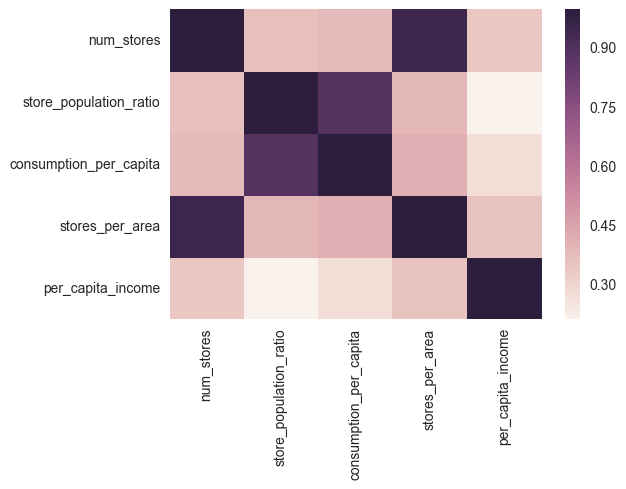

In [283]:
sns.heatmap(df_final[cols_to_keep].corr())

In [284]:
cols_to_keep_2 = ['sale_dollars','num_stores', 'store_population_ratio', 'consumption_per_capita', 'stores_per_area', u'per_capita_income', u'median_household_income', u'median_family_income']
df_final[cols_to_keep_2].corr()[['sale_dollars']].iloc[1:]

,sale_dollars
num_stores,0.995047
store_population_ratio,0.344187
consumption_per_capita,0.388819
stores_per_area,0.961106
per_capita_income,0.348343
median_household_income,0.190911
median_family_income,0.340245


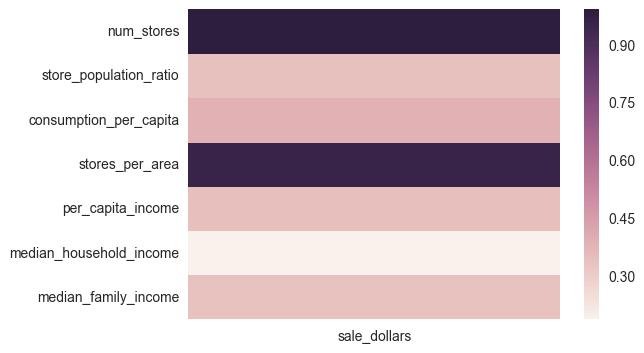

In [286]:
sns.heatmap(df_final[cols_to_keep_2].corr()[['sale_dollars']].iloc[1:]);

Let us generate scatter plots for all the predictors. They provide similar information as the correlation matrices.

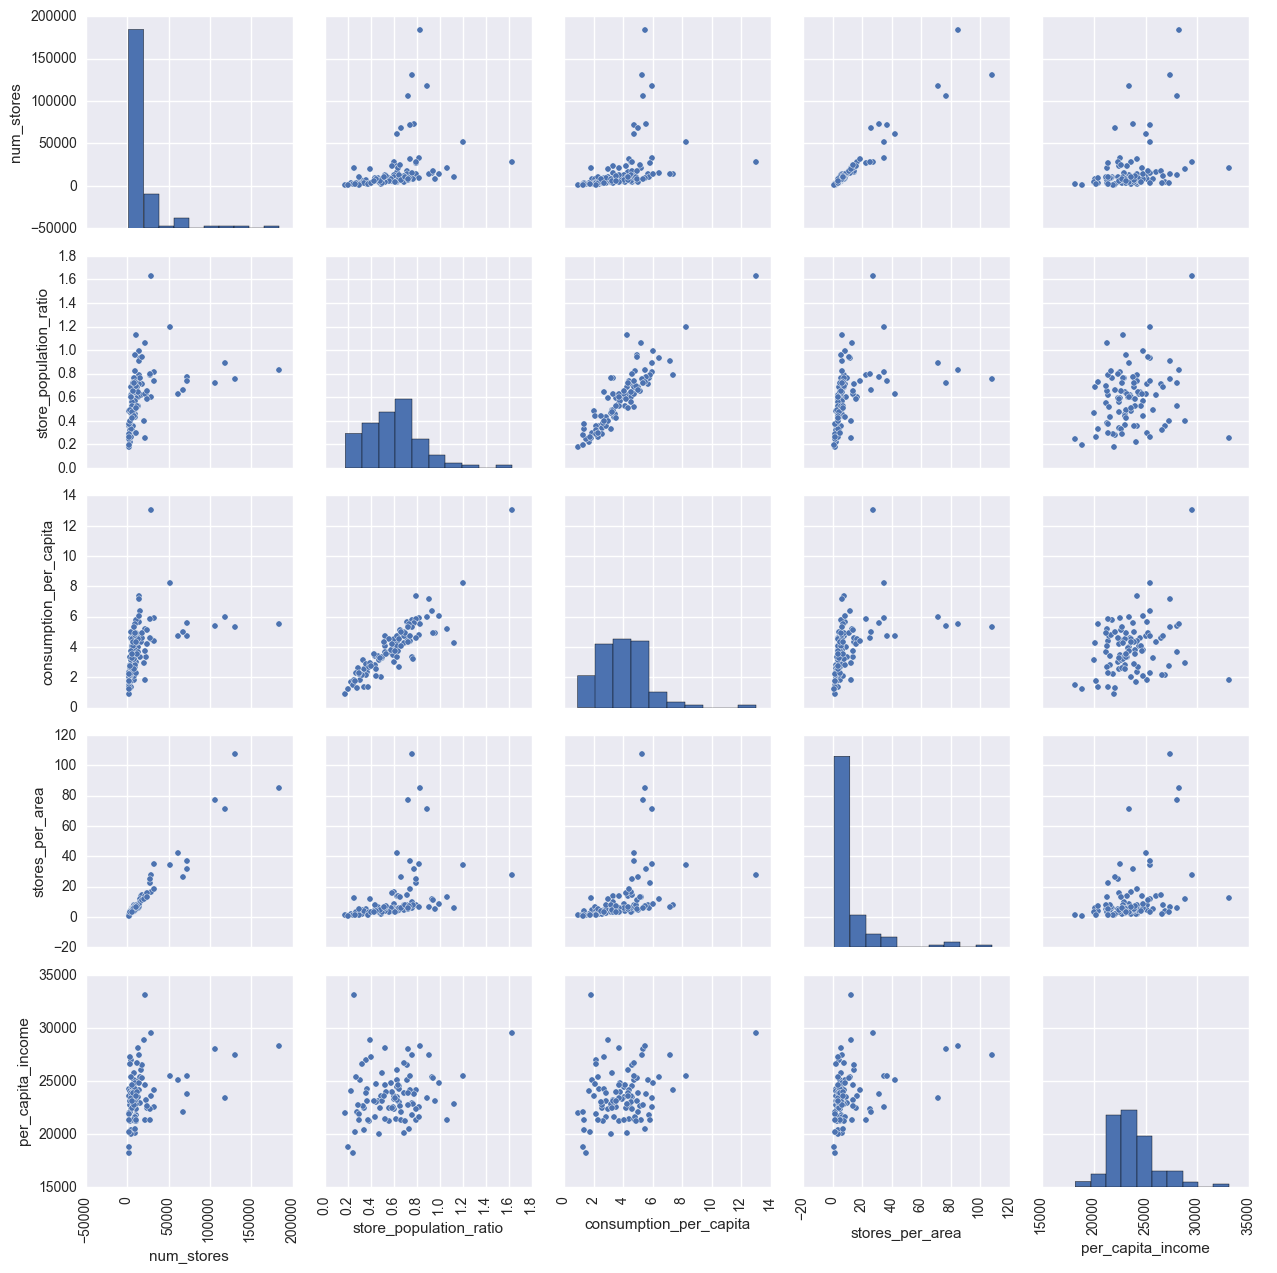

In [288]:
g = sns.pairplot(df_final[cols_to_keep])
for ax in g.axes.flatten():    # from [6]
    for tick in ax.get_xticklabels(): 
        tick.set(rotation=90);

# 7) Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [289]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

Let us first take a look at the 10 best performing counties (recall that we dropped Polk as an outlier):

In [290]:
df_final_sorted = df_final.copy()
df_final_sorted.sort_values("sale_dollars", inplace=True, ascending=False)
df_final_sorted[['county','sale_dollars']].head(10)

,county,sale_dollars
55,Linn,1.806775e+07
79,Scott,1.397399e+07
50,Johnson,1.237021e+07
6,Black Hawk,1.192076e+07
94,Woodbury,7.695638e+06
75,Pottawattamie,7.675324e+06
82,Story,6.730961e+06
30,Dubuque,6.621999e+06
16,Cerro Gordo,4.892826e+06
28,Des Moines,3.579586e+06


In [291]:
df_final_sorted[['county','sale_dollars']].tail(10)

,county,sale_dollars
56,Louisa,207146.11
26,Decatur,176364.48
86,Van Buren,174245.69
4,Audubon,159547.63
52,Keokuk,149560.78
77,Ringgold,138680.81
84,Taylor,110598.35
90,Wayne,105438.35
1,Adams,100596.80
25,Davis,96185.96


In [292]:
print df_final.columns.tolist()

['county', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters', 'profit', 'num_stores', 'average_store_profit', 'sales_per_litters', 'population', 'store_population_ratio', 'consumption_per_capita', 'area', 'stores_per_area', u'per_capita_income', u'median_household_income', u'median_family_income', u'number_of_households']


## Model Building

In [293]:
features = ['num_stores','population', 'store_population_ratio', \
 'consumption_per_capita',  'stores_per_area', u'per_capita_income']

In [294]:
X = df_final[features]
y = df_final['sale_dollars']

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [296]:
combs = []
for num in range(1,len(features)+1):
    combs.append([i[0] for i in list(itertools.combinations(features, num))])

We now create the training and testing data, instantiate the models and test all models you want:

In [297]:
lr = linear_model.LinearRegression(normalize=True)
ridge = linear_model.RidgeCV(cv=5)
lasso = linear_model.LassoCV(cv=5)
models = [lr,lasso,ridge]

Make a list of $R^2$ combinations:

In [298]:
r2_comb_lst = []
for comb in combs:        
    for m in models:
        model = m.fit(X_train[comb],y_train)
        r2 = m.score(X_test[comb], y_test)
        r2_comb_lst.append([round(r2,3),comb,str(model).split('(')[0]])

Find the best predictors using `itemgetter`:

In [299]:
import operator
r2_comb_lst.sort(key=operator.itemgetter(1))
print r2_comb_lst[-1]

[0.974, ['num_stores', 'population', 'store_population_ratio', 'consumption_per_capita', 'stores_per_area', u'per_capita_income'], 'RidgeCV']


The best predictors are:

In [300]:
r2_comb_lst[-1][1]

['num_stores',
 'population',
 'store_population_ratio',
 'consumption_per_capita',
 'stores_per_area',
 u'per_capita_income']

**Note:** Using

     str(model).split('(')[0]
  
  
on something like:
  
     LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))
     
we can extract only the model since we convert it to a string, split on `(` and get the first element

Dropping highly correlated predictors:

In [312]:
features=['population','store_population_ratio','stores_per_area',u'per_capita_income']

In [313]:
X = df_final[features]
y = df_final['sale_dollars']
ridge = linear_model.RidgeCV(cv=5)
model = ridge.fit(X,y)
print 'r-squared: {}'.format(model.score(X,y))

r-squared: 0.98031775254


In [314]:
coefficients = pd.DataFrame([features, model.coef_.tolist()], index=['feature', 'coefficients']).T
coefficients

,feature,coefficients
0,population,58.8369
1,store_population_ratio,1.05083e+06
2,stores_per_area,49967.5
3,per_capita_income,-71.6356


In [315]:
coefficients['coefficients'] = coefficients['coefficients'].astype(float)
coefficients = coefficients.sort_values(by='coefficients', ascending=False)

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

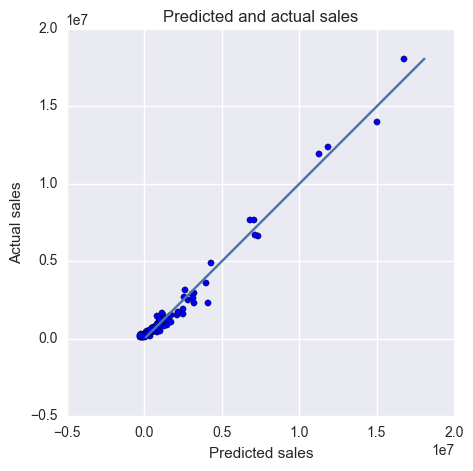

In [316]:
predicted = model.predict(X)
fig, ax = plt.subplots(figsize=(5,5));
plt.scatter(predicted, y);
plt.plot([min(y), max(y)], [min(y), max(y)], '-');
plt.title('Predicted and actual sales');
plt.xlabel('Predicted sales');
plt.ylabel('Actual sales');

In [317]:
pred = [round(p,0) for p in predicted]

## Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.


### Recommended counties

The counties with highest predicted total sales are below:

In [326]:
df_with_pred = df_final.copy()
df_with_pred['sales_prediction_dollars'] = pred
df_with_pred

,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores,average_store_profit,sales_per_litters,population,store_population_ratio,consumption_per_capita,area,stores_per_area,per_capita_income,median_household_income,median_family_income,number_of_households,sales_prediction_dollars
0,Adair,4455875,40182.62,6.037369e+04,33807,4.108056e+05,32522.35,1.374661e+05,4420,31.100932,12.631486,7092,0.623237,4.585780,1146.149874,3.856389,23497,45202,57287,3292,221482.0
1,Adams,1757403,18103.82,2.717139e+04,8446,1.005968e+05,7547.62,3.361478e+04,1797,18.706055,13.328281,3693,0.486596,2.043764,950.420482,1.890742,23549,40368,52782,1715,-224036.0
2,Allamakee,9079175,85371.49,1.282384e+05,57833,7.728435e+05,61269.76,2.586304e+05,8595,30.090802,12.613783,13884,0.619058,4.412976,1640.663925,5.238733,21349,46623,55926,5845,839656.0
3,Appanoose,8360175,82458.44,1.238400e+05,58261,7.113762e+05,53184.66,2.377927e+05,8582,27.708309,13.375589,12462,0.688654,4.267747,1439.625361,5.961273,20084,34689,41250,5627,955846.0
4,Audubon,2043175,17737.11,2.665607e+04,13978,1.595476e+05,13215.43,5.339370e+04,2045,26.109389,12.072829,5678,0.360162,2.327480,1011.305224,2.022139,24207,42717,58641,2617,-280677.0
5,Benton,7790725,71349.04,1.071595e+05,47699,5.803559e+05,47612.84,1.940870e+05,7731,25.105032,12.189062,25699,0.300829,1.852712,1589.039934,4.865202,25111,54726,64970,10302,912250.0
6,Black Hawk,100801227,1107541.37,1.663275e+06,1093412,1.192076e+07,793399.13,3.982880e+06,118229,33.687840,15.024919,132904,0.889582,5.969716,1658.463133,71.288290,23357,44178,57495,52470,11283189.0
7,Boone,16005831,154407.11,2.319393e+05,120271,1.534234e+06,115554.84,5.129844e+05,16515,31.061724,13.277107,26532,0.622456,4.355301,1172.618576,14.083864,25998,49578,66872,10728,1696331.0
8,Bremer,17767453,173326.87,2.603925e+05,113551,1.487074e+06,114021.43,4.976283e+05,17746,28.041717,13.042060,24798,0.715622,4.598009,1254.612988,14.144601,26522,55676,68602,9385,1657708.0
9,Buchanan,12168450,121504.75,1.824907e+05,89429,1.140914e+06,84484.18,3.814875e+05,12653,30.149961,13.504469,20992,0.602753,4.024589,1437.306002,8.803275,23437,51961,61421,8161,1269271.0


We notice that some of the predicted values are negative. This also happened in other works [1] and the reason is not quite clear. We remove them.

In [332]:
df_pred = df_with_pred[df_with_pred['sales_prediction_dollars']>0]
df_pred

,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,num_stores,average_store_profit,sales_per_litters,population,store_population_ratio,consumption_per_capita,area,stores_per_area,per_capita_income,median_household_income,median_family_income,number_of_households,sales_prediction_dollars
55,Linn,158353452,1731106.01,2.599613e+06,1500058,1.806775e+07,1221208.85,6.036068e+06,184092,32.788321,14.794975,221661,0.830511,5.509354,2164.866374,85.036195,28239,53674,69250,86134,16780528.0
79,Scott,112482102,1247750.11,1.873693e+06,1237025,1.397399e+07,914829.35,4.667888e+06,130419,35.791469,15.274967,172474,0.756166,5.304158,1211.649675,107.637548,27408,49964,64513,66765,14997255.0
50,Johnson,94201143,1094410.17,1.643462e+06,927749,1.237021e+07,784403.93,4.133645e+06,105955,39.013213,15.770199,146547,0.723010,5.352576,1374.398467,77.091908,28008,51380,74547,52715,11867678.0
6,Black Hawk,100801227,1107541.37,1.663275e+06,1093412,1.192076e+07,793399.13,3.982880e+06,118229,33.687840,15.024919,132904,0.889582,5.969716,1658.463133,71.288290,23357,44178,57495,52470,11283189.0
30,Dubuque,57322060,601825.15,9.038367e+05,501274,6.621999e+06,460080.11,2.212785e+06,60753,36.422653,14.393144,97003,0.626300,4.742947,1445.975306,42.015240,25045,48573,61138,36815,7310597.0
82,Story,65551096,727466.68,1.092625e+06,501832,6.730961e+06,456414.62,2.250349e+06,71636,31.413665,14.747469,97090,0.737831,4.700944,1943.690095,36.855670,25450,48248,74278,34736,7146093.0
94,Woodbury,61274387,672801.78,1.010242e+06,620680,7.695638e+06,512631.64,2.570501e+06,67732,37.951055,15.012023,102779,0.659006,4.987708,2591.144872,26.139797,22069,44343,55957,39052,7104739.0
75,Pottawattamie,64280187,680102.80,1.021141e+06,618358,7.675324e+06,521376.00,2.563352e+06,72472,35.370233,14.721285,93582,0.774422,5.571328,2303.225231,31.465442,23782,48728,60354,36775,6828297.0
16,Cerro Gordo,50439956,514818.96,7.732206e+05,377860,4.892826e+06,354343.00,1.635296e+06,51566,31.712671,13.808162,43070,1.197260,8.227142,1497.770139,34.428514,25463,44741,60148,19350,4328297.0
24,Dallas,19782703,208239.38,3.128030e+05,166032,2.295133e+06,151828.96,7.673762e+05,21284,36.054136,15.116572,84516,0.251834,1.796452,1727.389531,12.321483,33051,67037,84018,25240,4125161.0


#### Higher aggregated sales

Let us order the counties with higher predicted sales:

In [333]:
df_pred.sort_values("sales_prediction_dollars", inplace=True, ascending=False)
df_pred[['county','sales_per_litters','population','stores_per_area','sales_prediction_dollars']].head(4)

,county,sales_per_litters,population,stores_per_area,sales_prediction_dollars
55,Linn,14.794975,221661,85.036195,16780528.0
79,Scott,15.274967,172474,107.637548,14997255.0
50,Johnson,15.770199,146547,77.091908,11867678.0
6,Black Hawk,15.024919,132904,71.288290,11283189.0


In [337]:
df_pred.sort_values("population", inplace=True, ascending=False)
df_pred[['county','sales_per_litters','population','stores_per_area','sales_prediction_dollars']].head(4)

,county,sales_per_litters,population,stores_per_area,sales_prediction_dollars
55,Linn,14.794975,221661,85.036195,16780528.0
79,Scott,15.274967,172474,107.637548,14997255.0
50,Johnson,15.770199,146547,77.091908,11867678.0
6,Black Hawk,15.024919,132904,71.288290,11283189.0


Linn has higher sales which in part is because it has larger population which is not very useful information.

#### More high-end stores

Let us order by `sales_per_litters` to see which county has more high-end stores. 

In [338]:
df_pred.sort_values("sales_per_litters", inplace=True, ascending=False)
df_pred[['county','sales_per_litters','population','stores_per_area','sales_prediction_dollars']].head(4)

,county,sales_per_litters,population,stores_per_area,sales_prediction_dollars
50,Johnson,15.770199,146547,77.091908,11867678.0
79,Scott,15.274967,172474,107.637548,14997255.0
28,Des Moines,15.174117,39739,34.976332,3968601.0
24,Dallas,15.116572,84516,12.321483,4125161.0


We see that Johnson has more high-end stores. We would recommend it *if the goal of the the owner is to build new high-end stores*. If the plan is to open more stores but with cheaper products, Johnson is not the place to choose.

#### Saturation

The less saturated market is Decatur. But as discussed before this information does not provide have a unique recommendation and a more thorough analysis is needed.

In [344]:
df_pred.sort_values("stores_per_area", inplace=True, ascending=True)
df_pred[['county','sales_per_litters','population','stores_per_area','sales_prediction_dollars']]

,county,sales_per_litters,population,stores_per_area,sales_prediction_dollars
26,Decatur,14.405203,8141,1.381434,141811.0
52,Keokuk,11.481359,10119,1.782675,32440.0
11,Butler,11.140858,14791,1.929501,120103.0
39,Hancock,10.906219,10835,2.159491,58912.0
12,Calhoun,11.491468,9846,2.275235,68571.0
18,Chickasaw,11.530256,12023,3.024458,242653.0
70,Osceola,12.745341,6064,3.081288,15017.0
66,Monroe,13.831367,7870,3.122350,138773.0
74,Pocahontas,11.572587,6886,3.211730,166156.0
63,Mills,12.719923,14972,3.249919,142072.0


#### Competition

The county with weaker competition is Butler. This could provided untapped potential. However, the absence of a reasonable number of stores may indicate, as observed before, that the county's population is simply not interested in this category of product. Again, further investigation must be carried out.

In [347]:
df_pred.sort_values("store_population_ratio", inplace=True, ascending=True)
df_pred[['county','sales_per_litters','population','stores_per_area','sales_prediction_dollars','store_population_ratio']]

,county,sales_per_litters,population,stores_per_area,sales_prediction_dollars,store_population_ratio
11,Butler,11.140858,14791,1.929501,120103.0,0.223650
26,Decatur,14.405203,8141,1.381434,141811.0,0.244933
24,Dallas,15.116572,84516,12.321483,4125161.0,0.251834
63,Mills,12.719923,14972,3.249919,142072.0,0.265028
52,Keokuk,11.481359,10119,1.782675,32440.0,0.276411
39,Hancock,10.906219,10835,2.159491,58912.0,0.286202
81,Sioux,13.538806,34898,5.012698,1725739.0,0.295346
5,Benton,12.189062,25699,4.865202,912250.0,0.300829
27,Delaware,13.760907,17327,4.507389,615781.0,0.331794
56,Louisa,13.987210,11142,3.802603,378171.0,0.334769
